In [1]:
import os
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import os
DATASET_DIR = r"D:\actvity\datasets"
classes = os.listdir(DATASET_DIR)
print("Classes:", classes)
for cls in classes:
    cls_path = os.path.join(DATASET_DIR, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")

Classes: ['Ripenes', 'Unripen']
Ripenes: 388 images
Unripen: 629 images


In [5]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds.class_names
print("Class names:", class_names)

Found 1017 files belonging to 2 classes.
Using 814 files for training.
Found 1017 files belonging to 2 classes.
Using 203 files for validation.
Class names: ['Ripenes', 'Unripen']


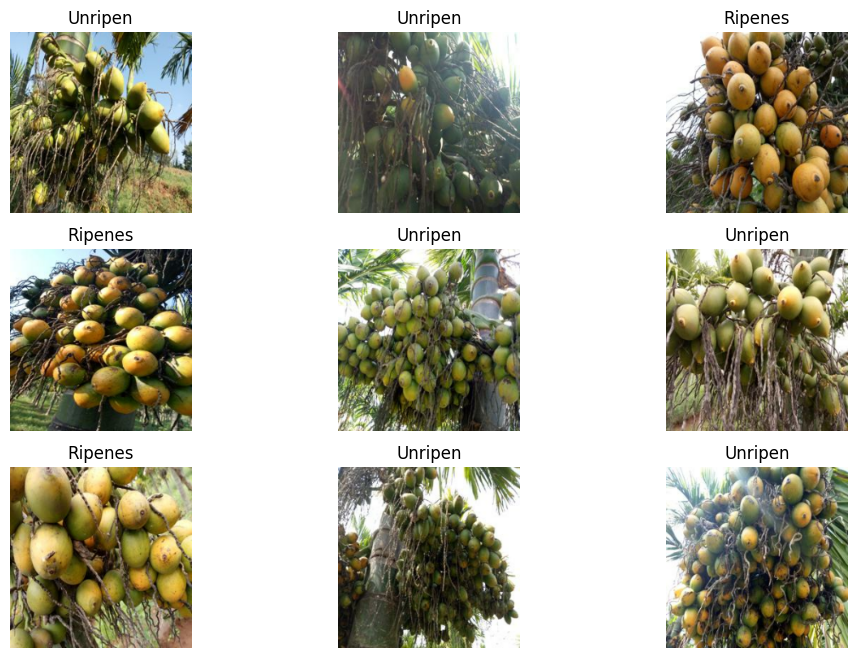

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [7]:
class_weight = {
    0: 629 / 388,
    1:1.0
}

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1), 
])

In [33]:
def build_head(x):
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    return tf.keras.layers.Dense(1, activation="sigmoid")(x)


In [34]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

In [38]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# IMPORTANT: training=False
x = base_model(x, training=False)

# ONLY ONE POOLING
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

# Dense head (ONCE)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

training_model = tf.keras.Model(inputs, outputs)


In [39]:
# inputs = keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
# x = base_model(x, training=True)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dense(512, activation="relu")(x)
# x = layers.Dropout(0.3)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model = keras.Model(inputs, outputs)

In [40]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=16,
    class_weight=class_weight
)

Epoch 1/16
51/51 [==============================] - 7s 128ms/step - loss: 0.3524 - accuracy: 0.8415 - val_loss: 0.4358 - val_accuracy: 0.8374
Epoch 2/16
51/51 [==============================] - 6s 121ms/step - loss: 0.4401 - accuracy: 0.8722 - val_loss: 0.4269 - val_accuracy: 0.8325
Epoch 3/16
51/51 [==============================] - 6s 121ms/step - loss: 0.3695 - accuracy: 0.8575 - val_loss: 0.4446 - val_accuracy: 0.8374
Epoch 4/16
51/51 [==============================] - 6s 122ms/step - loss: 0.3552 - accuracy: 0.8600 - val_loss: 0.4477 - val_accuracy: 0.8227
Epoch 5/16
51/51 [==============================] - 6s 122ms/step - loss: 0.3737 - accuracy: 0.8686 - val_loss: 0.5475 - val_accuracy: 0.8177
Epoch 6/16
51/51 [==============================] - 7s 131ms/step - loss: 0.3965 - accuracy: 0.8747 - val_loss: 0.5272 - val_accuracy: 0.7931
Epoch 7/16
51/51 [==============================] - 6s 125ms/step - loss: 0.3541 - accuracy: 0.8857 - val_loss: 0.4741 - val_accuracy: 0.8177
Epoch 

In [49]:
def confidence_decision(p):
    if p <= 0.4:
        return 0      # Ripen
    elif p >= 0.6:
        return 1      # Unripen
    else:
        return -1     # Uncertain


In [50]:
import numpy as np

y_true = []
y_prob = []

for images, labels in val_ds:
    probs = model.predict(images)
    y_prob.extend(probs.flatten())
    y_true.extend(labels.numpy())

y_prob = np.array(y_prob)
y_true = np.array(y_true)
y_pred_conf = np.array([confidence_decision(p) for p in y_prob])

confident_idx = y_pred_conf != -1

y_true_conf = y_true[confident_idx]
y_pred_confident = y_pred_conf[confident_idx]

from sklearn.metrics import accuracy_score

conf_accuracy = accuracy_score(y_true_conf, y_pred_confident)
coverage = len(y_true_conf) / len(y_true)

conf_accuracy, coverage


1/1 [==============================] - 0s 31ms/step


(0.8641304347826086, 0.9064039408866995)

In [51]:
# import numpy as np
# y_true = []
# y_pred = []
# for images, labels in val_ds:
#     preds = model.predict(images)
#     preds = (preds > 0.5).astype(int).flatten()
#     y_true.extend(labels.numpy())
#     y_pred.extend(preds)

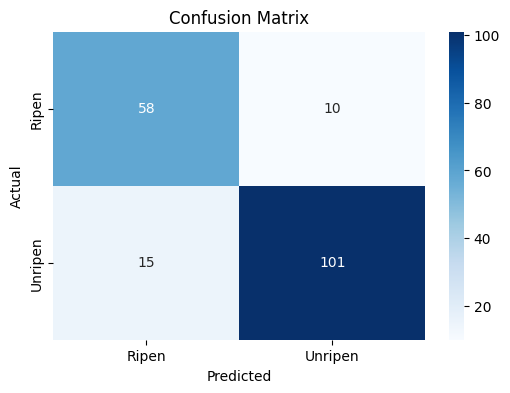

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true_conf, y_pred_confident)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=["Ripen", "Unripen"],
    yticklabels=["Ripen", "Unripen"],
    cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [53]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_true_conf, y_pred_confident))
print(classification_report(y_true_conf, y_pred_confident,
                            target_names=["Ripen", "Unripen"]))


[[ 58  10]
 [ 15 101]]
              precision    recall  f1-score   support

       Ripen       0.79      0.85      0.82        68
     Unripen       0.91      0.87      0.89       116

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.87      0.86      0.87       184



In [54]:
# from sklearn.metrics import classification_report
# print(classification_report(
#     y_true,
#     y_pred,
#     target_names=["Ripen", "Unripen"] 
# ))

In [62]:
model.save("arecanut_maturity.keras")

In [57]:
# import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()
# with open("arecanut_maturity.tflite", "wb") as f:
#     f.write(tflite_model)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_mobilenet_training.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [65]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=16,
    callbacks=callbacks
)


Epoch 1/16


51/51 [==============================] - 14s 144ms/step - loss: 0.2895 - accuracy: 0.8870 - val_loss: 0.6126 - val_accuracy: 0.8177
Epoch 2/16
51/51 [==============================] - 6s 124ms/step - loss: 0.2618 - accuracy: 0.8821 - val_loss: 0.8069 - val_accuracy: 0.8079
Epoch 3/16
51/51 [==============================] - 7s 128ms/step - loss: 0.2474 - accuracy: 0.8980 - val_loss: 0.5962 - val_accuracy: 0.8276
Epoch 4/16
51/51 [==============================] - 7s 128ms/step - loss: 0.2865 - accuracy: 0.8882 - val_loss: 0.8426 - val_accuracy: 0.8079
Epoch 5/16
51/51 [==============================] - 6s 126ms/step - loss: 0.2663 - accuracy: 0.8870 - val_loss: 0.4680 - val_accuracy: 0.8325
Epoch 6/16
51/51 [==============================] - 7s 137ms/step - loss: 0.2808 - accuracy: 0.8796 - val_loss: 0.4407 - val_accuracy: 0.8424
Epoch 7/16
51/51 [==============================] - 7s 130ms/step - loss: 0.2750 - accuracy: 0.8956 - val_loss: 0.5058 - val_accuracy: 0.8177
Epoch 8/16
51/51

1/1 [==============================] - 0s 33ms/step


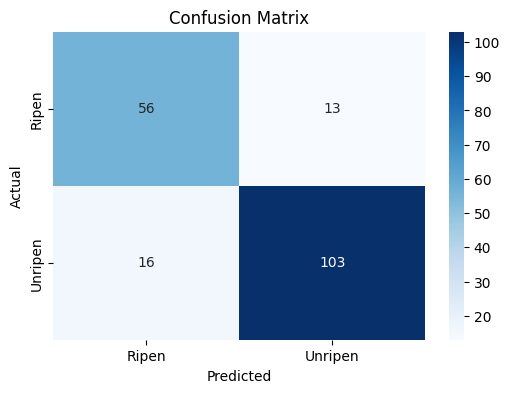

[[ 56  13]
 [ 16 103]]
              precision    recall  f1-score   support

       Ripen       0.78      0.81      0.79        69
     Unripen       0.89      0.87      0.88       119

    accuracy                           0.85       188
   macro avg       0.83      0.84      0.84       188
weighted avg       0.85      0.85      0.85       188



In [66]:
def confidence_decision(p):
    if p <= 0.4:
        return 0      # Ripen
    elif p >= 0.6:
        return 1      # Unripen
    else:
        return -1     # Uncertain

import numpy as np

y_true = []
y_prob = []

for images, labels in val_ds:
    probs = model.predict(images)
    y_prob.extend(probs.flatten())
    y_true.extend(labels.numpy())

y_prob = np.array(y_prob)
y_true = np.array(y_true)
y_pred_conf = np.array([confidence_decision(p) for p in y_prob])

confident_idx = y_pred_conf != -1

y_true_conf = y_true[confident_idx]
y_pred_confident = y_pred_conf[confident_idx]

from sklearn.metrics import accuracy_score

conf_accuracy = accuracy_score(y_true_conf, y_pred_confident)
coverage = len(y_true_conf) / len(y_true)

conf_accuracy, coverage


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true_conf, y_pred_confident)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=["Ripen", "Unripen"],
    yticklabels=["Ripen", "Unripen"],
    cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_true_conf, y_pred_confident))
print(classification_report(y_true_conf, y_pred_confident,
                            target_names=["Ripen", "Unripen"]))


In [69]:
inference_inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inference_inputs)
x = base_model(x, training=False)

# x = layers.GlobalAveragePooling2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dense(128, activation="relu")(x)

inf_outputs = build_head(x)
inference_model = tf.keras.Model(inference_inputs, inf_outputs)

In [70]:
inference_model.set_weights(training_model.get_weights())

ValueError: You called `set_weights(weights)` on layer "model_3" with a weight list of length 272, but the layer was expecting 270 weights. Provided weights: [array([[[[-1.71659231e-01, -3.33731920e-01,  5.30...

In [71]:
for layer in inference_model.layers:
    layer.trainable = False

inference_model.save(
    "arecanut_maturity_mobilenet",
    include_optimizer=False
)


INFO:tensorflow:Assets written to: arecanut_maturity_mobilenet\assets


INFO:tensorflow:Assets written to: arecanut_maturity_mobilenet\assets


In [72]:
converter = tf.lite.TFLiteConverter.from_saved_model(
    "arecanut_maturity_mobilenet"
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

with open("arecanut_maturity_mobilenet.tflite", "wb") as f:
    f.write(tflite_model)
